In [2]:
%matplotlib inline

In [3]:
# Data
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn import preprocessing

In [4]:
# Visualization
import seaborn as sns
sns.set_style('darkgrid')

In [5]:
import platform
if platform.system() == 'Windows':
    import os
    os.chdir('C:/Users/Lordzsolt/_PythonStuff/Kaggle/Titanic/src')

In [6]:
trainDF = pd.read_csv("../input/train.csv")
testDF = pd.read_csv("../input/test.csv")

# Check for outliers

In [7]:
# Outlier detection 

def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(trainDF, 2, ["Age", "SibSp", "Parch", "Fare"])
trainDF.loc[Outliers_to_drop]

trainDF = trainDF.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

C:\Developer\PythonStuff\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [8]:
train_len = len(trainDF)
combineDF = pd.concat([trainDF, testDF], axis=0).reset_index(drop=True)
combineDF = combineDF.fillna(np.nan)
nulls = combineDF.isnull().sum().sort_values(ascending=False)
nulls = nulls[nulls > 0]

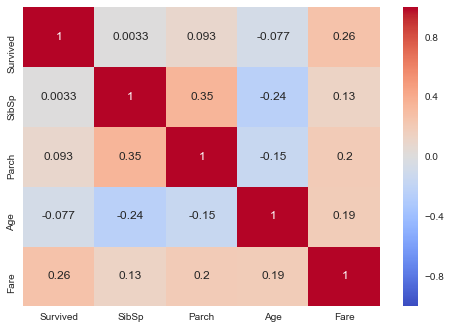

In [9]:
sns.heatmap(combineDF[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, cmap='coolwarm')

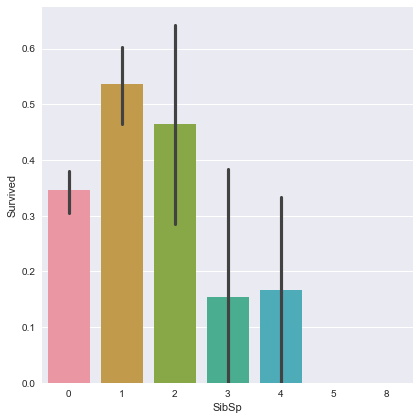

In [10]:
sns.factorplot(x='SibSp', y='Survived', data=combineDF, kind='bar', size=6)

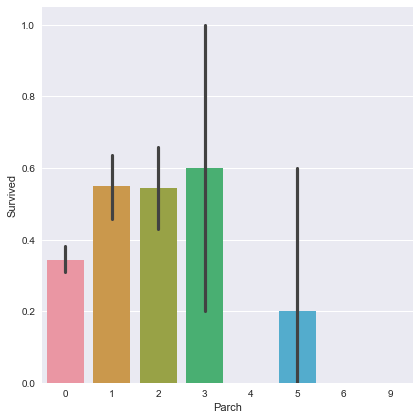

In [11]:
sns.factorplot(x='Parch', y='Survived', data=combineDF, kind='bar', size=6)

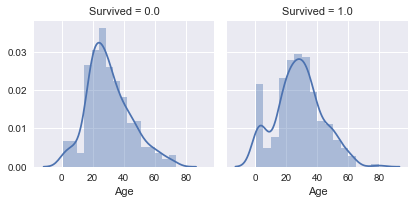

In [12]:
g = sns.FacetGrid(combineDF, col='Survived')
g = g.map(sns.distplot, "Age")

In [13]:
combineDF['Fare'] = combineDF['Fare'].fillna(combineDF['Fare'].median())

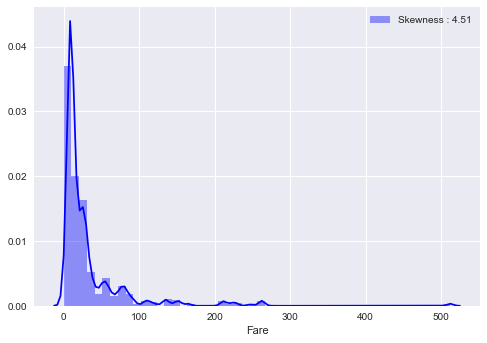

In [14]:
fares = combineDF['Fare']
g = sns.distplot(fares, color='b', label="Skewness : %.2f"%(fares.skew()))
g = g.legend(loc='best')

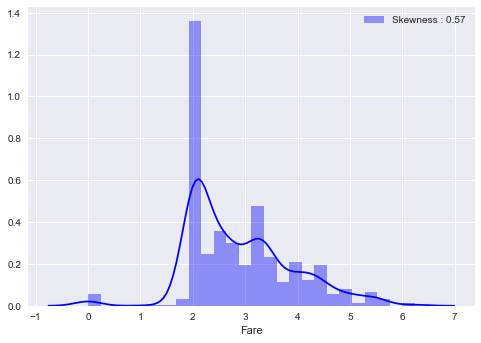

In [15]:
combineDF['Fare'] = fares.map(lambda x: np.log(x) if x > 0 else 0)

fares = combineDF['Fare']
g = sns.distplot(fares, color='b', label="Skewness : %.2f"%(fares.skew()))
g = g.legend(loc='best')

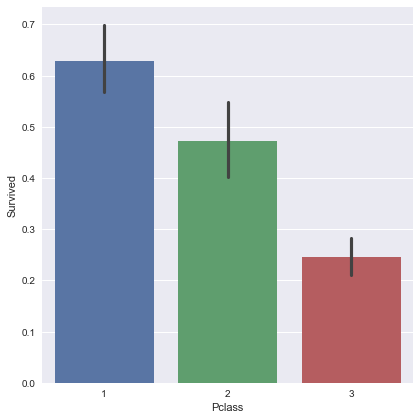

In [16]:
sns.factorplot(x='Pclass', y='Survived', data=combineDF, kind="bar", size=6)

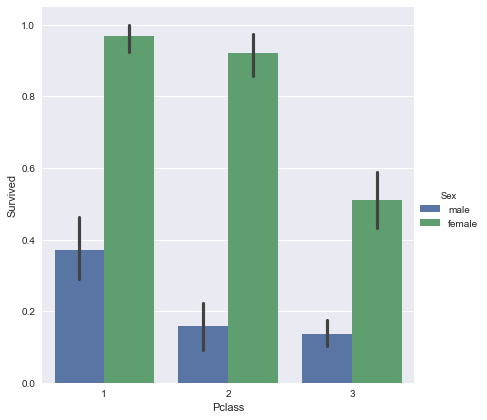

In [17]:
sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=combineDF, kind="bar", size=6)

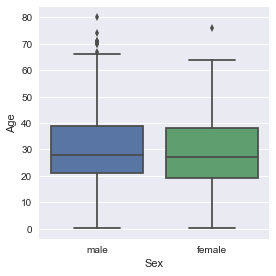

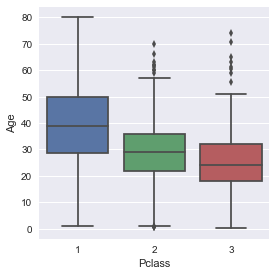

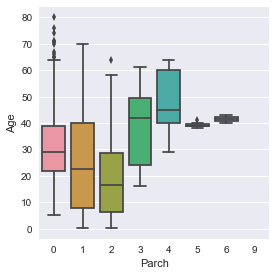

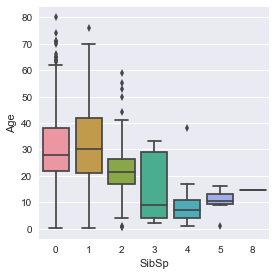

In [18]:
g = sns.factorplot(y='Age', x='Sex', data=combineDF, kind="box")
g = sns.factorplot(y='Age', x='Pclass', data=combineDF, kind="box")
g = sns.factorplot(y='Age', x='Parch', data=combineDF, kind="box")
g = sns.factorplot(y='Age', x='SibSp', data=combineDF, kind="box")

In [19]:
combineDF['Sex'] = combineDF['Sex'].map({'male': 0, 'female': 1})
combineDF.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450


# Explore and fill missing Age values

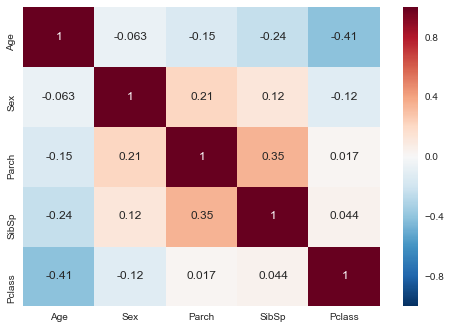

In [20]:
sns.heatmap(combineDF[['Age', 'Sex', 'Parch', 'SibSp', 'Pclass']].corr(), annot=True)

In [21]:
# Pclass, SibSp, Parch
pclasses = set(combineDF['Pclass'])
sibsps = set(combineDF['SibSp'])
parchs = set(combineDF['Parch'])

median = combineDF['Age'].median()

groupMedian = {}

for pclass in pclasses:
    groupMedian[pclass] = {}
    for sibsp in sibsps:
        groupMedian[pclass][sibsp] = {}
        for parch in parchs:
            currentMedian = combineDF['Age'][((combineDF['Pclass'] == pclass) & (combineDF['SibSp'] == sibsp) & (combineDF['Parch'] == parch))].median()
            if not np.isnan(currentMedian):
                groupMedian[pclass][sibsp][parch] = currentMedian
            else:
                groupMedian[pclass][sibsp][parch] = median
            
missingAges = list(combineDF['Age'][combineDF['Age'].isnull()].index)
for index in missingAges:
    combineDF.loc[index, 'Age'] = groupMedian[combineDF['Pclass'][index]][combineDF['SibSp'][index]][combineDF['Parch'][index]]

# Extract title from name and explore

In [22]:
r = re.compile('(\w*)(\.)')
titles = list(map(lambda x: r.search(x).group(1), combineDF['Name']))
c = Counter(titles)
c.items()

dict_items([('Mr', 753), ('Mrs', 197), ('Miss', 255), ('Master', 60), ('Don', 1), ('Rev', 8), ('Dr', 8), ('Mme', 1), ('Ms', 2), ('Major', 2), ('Lady', 1), ('Sir', 1), ('Mlle', 2), ('Col', 4), ('Capt', 1), ('Countess', 1), ('Jonkheer', 1), ('Dona', 1)])

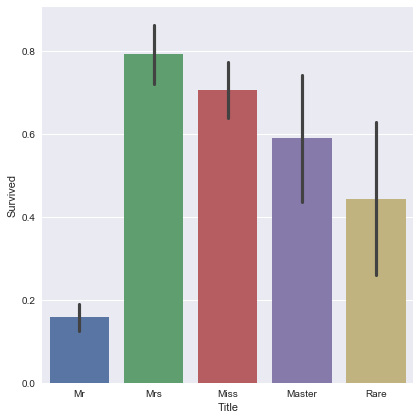

In [23]:
titles = list(map(lambda x: x if c[x] > 10 else 'Rare', titles))
combineDF['Title'] = titles
sns.factorplot(x='Title', y='Survived', data=combineDF, kind="bar", size=6)

In [24]:
combineDF.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,Mr
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,Mrs
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,Mr


# Explore Family Size

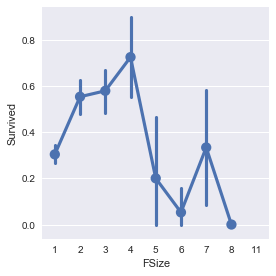

In [25]:
combineDF['FSize'] = combineDF['SibSp'] + combineDF['Parch'] + 1
sns.factorplot(x='FSize', y='Survived', data=combineDF)

In [26]:
def group_fsize(x): 
    if x == 1:
        return "Alone"
    elif x == 2:
        return "Small"
    elif 3 <= x <= 4:
        return "Medium"
    else:
        return "Large"

combineDF['FGroup'] = list(map(group_fsize, combineDF['FSize']))

# Explore Cabin

In [27]:
combineDF['Cabin'] = combineDF['Cabin'].fillna('X')
combineDF['Cabin'] = list(map(lambda x: x[0], combineDF['Cabin']))

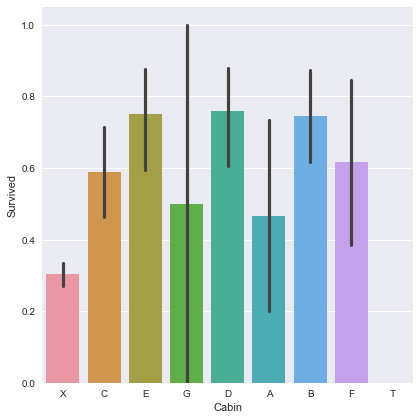

In [28]:
sns.factorplot(x='Cabin', y='Survived', data=combineDF, kind="bar", size=6)

# Explore Ticket

In [29]:
Ticket = []
for i in list(combineDF.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
combineDF["Ticket"] = Ticket
combineDF["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

# Drop unused fiels

In [30]:
combineDF.drop(labels=['Name'], axis=1, inplace=True)
combineDF.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FSize,FGroup
0,22.0,X,S,1.981001,0,1,3,0,1,0.0,A5,Mr,2,Small
1,38.0,C,C,4.266662,0,2,1,1,1,1.0,PC,Mrs,2,Small
2,26.0,X,S,2.070022,0,3,3,1,0,1.0,STONO2,Miss,1,Alone
3,35.0,C,S,3.972177,0,4,1,1,1,1.0,X,Mrs,2,Small
4,35.0,X,S,2.085672,0,5,3,0,0,0.0,X,Mr,1,Alone


# Create dummy variables

In [31]:
combineDF = pd.get_dummies(combineDF, columns=['Cabin'])
combineDF = pd.get_dummies(combineDF, columns=['Embarked'])
combineDF = pd.get_dummies(combineDF, columns=['Title'])
combineDF = pd.get_dummies(combineDF, columns=['FGroup'])
combineDF = pd.get_dummies(combineDF, columns=['Pclass'])
combineDF = pd.get_dummies(combineDF, columns=['Ticket'])
combineDF.head()

,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,FSize,Cabin_A,Cabin_B,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X
0,22.0,1.981001,0,1,0,1,0.0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38.0,4.266662,0,2,1,1,1.0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26.0,2.070022,0,3,1,0,1.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,35.0,3.972177,0,4,1,1,1.0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
4,35.0,2.085672,0,5,0,0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# Feature Scaling

In [32]:
train = combineDF[:train_len].copy()
test = combineDF[train_len:].copy()

labels = ['Age', 'Fare', 'Parch', 'SibSp', 'FSize']
scaler = preprocessing.StandardScaler().fit(train[labels])
train[labels] = scaler.transform(train[labels])
test[labels] = scaler.transform(test[labels])

# Save modified data

In [33]:
test.drop(labels=['Survived'], axis=1, inplace=True)

train.to_csv('../output/train.csv', index=False)
test.to_csv('../output/test.csv', index=False)